In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load Data
tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=tensor_mode, download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=tensor_mode, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 86771711.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23902070.60it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23937460.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5964473.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [51]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

In [5]:
temp = next(iter(trainloader))

In [7]:
temp[0].shape

torch.Size([128, 1, 28, 28])

In [17]:
temp[0][0,].shape

torch.Size([1, 28, 28])

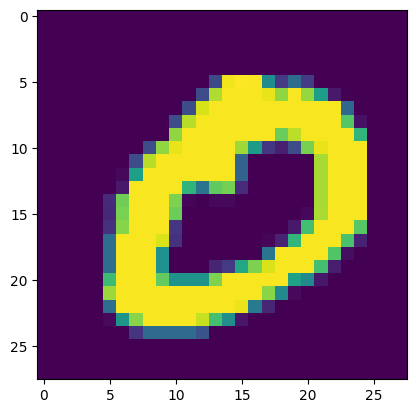

In [19]:
plt.imshow(temp[0][0,].permute(1,2,0))

In [24]:
temp[0][0, 0, ].shape

torch.Size([28, 28])

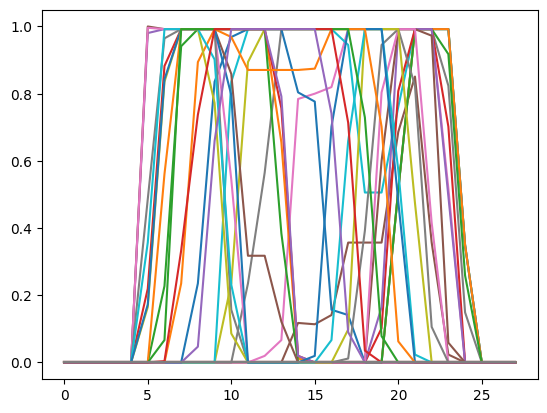

In [26]:
plt.plot(temp[0][0, 0, :].numpy());

In [52]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, num_classes, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc = nn.Linear(seq_length*hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        # print(f"h0 : {h0.shape}") torch.Size([4, 128, 12])
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        # print(f"c0 : {c0.shape}") torch.Size([4, 128, 12])
        out, _ = self.lstm(x, (h0, c0))
        # print(f"out : {out.shape}") torch.Size([128, 28, 24])

        #out = self.fc(out[:, -1, :])
        out = out.reshape(-1, self.seq_length * self.hidden_size * 2)
        # print(f"out : {out.shape}") torch.Size([128, 672])
        out = self.fc(out)
        return out

In [49]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, num_classes, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc = nn.Linear(seq_length*hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        print(f"h0 : {h0.shape}")
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device)
        print(f"c0 : {c0.shape}")
        out, _ = self.lstm(x, (h0, c0))
        print(f"out : {out.shape}")

        out = self.fc(out[:, -1, :])
        print(f"fc out : {out.shape}")
        out = out.reshape(-1, self.seq_length * self.hidden_size * 2)
        print(f"reshape out : {out.shape}")
        out = self.fc(out)
        return out

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
sequence_length = trainset.data.size(1) # 28
input_size = trainset.data.size(2)      # 28
num_layers = 2
hidden_size = 12
num_classes = 10

In [55]:
model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)

In [34]:
model.parameters

<bound method Module.parameters of BiLSTM(
  (lstm): LSTM(28, 12, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=672, out_features=10, bias=True)
)>

In [48]:
model.parameters

<bound method Module.parameters of BiLSTM(
  (lstm): LSTM(28, 12, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=24, out_features=10, bias=True)
)>

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [35]:
from tqdm import tqdm

In [57]:
for epoch in tqdm(range(51)):
    correct = 0
    total = 0
    for data in trainloader:
        optimizer.zero_grad()
        inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.detach(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('[%d] train acc: %.2f' %(epoch, 100 * correct / total))

  2%|▏         | 1/51 [00:32<27:01, 32.42s/it]

[0] train acc: 91.61


  4%|▍         | 2/51 [00:59<23:56, 29.32s/it]

[1] train acc: 97.52


  6%|▌         | 3/51 [01:26<22:43, 28.41s/it]

[2] train acc: 98.15


  8%|▊         | 4/51 [01:57<22:49, 29.13s/it]

[3] train acc: 98.52


 10%|▉         | 5/51 [02:26<22:26, 29.27s/it]

[4] train acc: 98.79


 12%|█▏        | 6/51 [02:58<22:31, 30.03s/it]

[5] train acc: 98.86


 14%|█▎        | 7/51 [03:25<21:22, 29.14s/it]

[6] train acc: 99.03


 16%|█▌        | 8/51 [03:52<20:27, 28.55s/it]

[7] train acc: 99.09


 18%|█▊        | 9/51 [04:20<19:50, 28.35s/it]

[8] train acc: 99.26


 20%|█▉        | 10/51 [04:47<19:08, 28.02s/it]

[9] train acc: 99.24


 22%|██▏       | 11/51 [05:15<18:31, 27.79s/it]

[10] train acc: 99.36


 24%|██▎       | 12/51 [05:42<17:57, 27.62s/it]

[11] train acc: 99.37


 25%|██▌       | 13/51 [06:09<17:24, 27.50s/it]

[12] train acc: 99.38


 27%|██▋       | 14/51 [06:36<16:54, 27.42s/it]

[13] train acc: 99.55


 29%|██▉       | 15/51 [07:05<16:36, 27.69s/it]

[14] train acc: 99.52


 31%|███▏      | 16/51 [07:32<16:08, 27.68s/it]

[15] train acc: 99.55


 33%|███▎      | 17/51 [08:00<15:37, 27.56s/it]

[16] train acc: 99.55


 35%|███▌      | 18/51 [08:27<15:06, 27.46s/it]

[17] train acc: 99.48


 37%|███▋      | 19/51 [08:54<14:37, 27.41s/it]

[18] train acc: 99.62


 39%|███▉      | 20/51 [09:21<14:08, 27.36s/it]

[19] train acc: 99.60


 41%|████      | 21/51 [09:49<13:39, 27.33s/it]

[20] train acc: 99.60


 43%|████▎     | 22/51 [10:16<13:16, 27.48s/it]

[21] train acc: 99.73


 45%|████▌     | 23/51 [10:45<12:54, 27.68s/it]

[22] train acc: 99.74


 47%|████▋     | 24/51 [11:12<12:23, 27.52s/it]

[23] train acc: 99.65


 49%|████▉     | 25/51 [11:39<11:52, 27.39s/it]

[24] train acc: 99.63


 51%|█████     | 26/51 [12:06<11:23, 27.34s/it]

[25] train acc: 99.78


 53%|█████▎    | 27/51 [12:33<10:55, 27.30s/it]

[26] train acc: 99.65


 55%|█████▍    | 28/51 [13:01<10:27, 27.30s/it]

[27] train acc: 99.74


 57%|█████▋    | 29/51 [13:29<10:04, 27.48s/it]

[28] train acc: 99.75


 59%|█████▉    | 30/51 [13:56<09:40, 27.63s/it]

[29] train acc: 99.69


 61%|██████    | 31/51 [14:24<09:10, 27.51s/it]

[30] train acc: 99.82


 63%|██████▎   | 32/51 [14:51<08:41, 27.43s/it]

[31] train acc: 99.73


 65%|██████▍   | 33/51 [15:18<08:12, 27.38s/it]

[32] train acc: 99.69


 67%|██████▋   | 34/51 [15:46<07:45, 27.40s/it]

[33] train acc: 99.78


 67%|██████▋   | 34/51 [15:57<07:58, 28.17s/it]


KeyboardInterrupt: ignored

In [58]:
def accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, labels = data[0].to(device).squeeze(1), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100*correct/total
    model.train()
    return acc

In [59]:
train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)
print("Train Acc: %.1f, Test Acc: %.1f" %(train_acc, test_acc))

Train Acc: 99.9, Test Acc: 98.9
